<a href="https://colab.research.google.com/github/harinivas04/Realtime-pest-and-intruder-detection-using-ResNet50-model/blob/main/pest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14346 sha256=262a1980056f01f392ec77cd87d62eb5010e104047779d624b4338a3dac6e7f2
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [ ]:
!pip install --upgrade gradio

In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from PIL import Image, ImageDraw
import wikipediaapi
import folium
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the ResNet50 model
try:
    model = ResNet50(weights="imagenet")
except Exception as e:
    raise RuntimeError(f"Error loading TensorFlow model: {str(e)}")

# Initialize Wikipedia API for fetching insect details
user_agent = "MyInsectDetectionApp/1.0 (contact@example.com)"
wiki_wiki = wikipediaapi.Wikipedia(language='en', user_agent=user_agent)

# Define colors for different pests on the map
PEST_COLORS = {
    "grasshopper": "green",
    "slug": "blue",
    "bee": "yellow",
    "ant": "red",
    "weevil": "purple",
    "snail": "orange",
    "beetle": "pink",
    "leafhopper": "darkgreen",
    "earthworm": "brown",
    "spider": "gray",
}

def detect_insect_with_tensorflow(img):
    try:
        img = img.resize((224, 224))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = img_array[None, ...]
        preds = model.predict(img_array)
        decoded_preds = decode_predictions(preds, top=1)[0]
        insect_name = decoded_preds[0][1]
        return insect_name
    except Exception as e:
        return f"Error in TensorFlow detection: {str(e)}"

def fetch_insect_info(insect_name):
    try:
        page = wiki_wiki.page(insect_name)
        if page.exists():
            full_info = page.text
            eradication_keywords = ["control", "management", "eradication", "prevent", "remove"]
            pesticide_keywords = ["pesticide", "insecticide", "treatment", "chemical", "biological control"]

            def extract_relevant_content(keywords):
                relevant_lines = []
                for line in full_info.splitlines():
                    if any(keyword in line.lower() for keyword in keywords):
                        relevant_lines.append(line.strip())
                return "\n".join(relevant_lines) if relevant_lines else None

            eradication_methods = extract_relevant_content(eradication_keywords)
            pesticides_used = extract_relevant_content(pesticide_keywords)

            result = f"*Full Information about {insect_name}:*\n\n{full_info}\n\n"

            if eradication_methods:
                result += f"*Eradication Methods:*\n{eradication_methods}\n\n"
            else:
                result += "No specific eradication methods found.\n\n"

            if pesticides_used:
                result += f"*Pesticides to Be Used:*\n{pesticides_used}\n\n"
            else:
                result += "No specific pesticides found.\n\n"

            return result
        else:
            return f"Details for {insect_name} are not available on Wikipedia."
    except Exception as e:
        return f"Error fetching insect info: {str(e)}"

def highlight_insect_on_image(img, insect_name):
    try:
        width, height = img.size
        draw = ImageDraw.Draw(img)
        box_width = int(width * 0.6)
        box_height = int(height * 0.6)
        left = int(width * 0.2)
        top = int(height * 0.2)
        right = left + box_width
        bottom = top + box_height
        draw.rectangle([left, top, right, bottom], outline="red", width=5)
        return img
    except Exception as e:
        return img  # Return the original image in case of error

def generate_map(locations_with_pests):
    try:
        folium_map = folium.Map(location=[0, 0], zoom_start=2)
        for loc, pest_name in locations_with_pests:
            if loc:
                # Ensure pest_name is a string and handle None or invalid types
                pest_name_str = str(pest_name).lower() if pest_name else "unknown"
                color = PEST_COLORS.get(pest_name_str, "gray")

                folium.Marker(
                    location=loc,
                    popup=f"Detected Pest: {pest_name}",
                    icon=folium.Icon(color=color)
                ).add_to(folium_map)

        # Generate the HTML representation of the map
        map_html = folium_map._repr_html_()
        return map_html
    except Exception as e:
        return f"<p>Error generating map: {str(e)}</p>"

def get_insect_location(insect_name):
    try:
        insect_locations = {
            "grasshopper": [(13.5, 2.1), (39.5, -98.5), (20.6, 78.9)],
            "slug": [(55.3, -3.4), (45.5, -122.7), (-40.9, 174.9)],
            "bee": [(36.7, -119.4), (20.6, 78.9), (41.9, 12.5)],
            "ant": [(-3.4, -62.2), (-0.8, 113.9), (-2.9, 23.6)],
            "weevil": [(31.0, -100.0), (20.6, 78.9), (35.9, 104.2)],
            "snail": [(46.6, 2.2), (36.2, 138.3), (45.5, -122.7)],
            "beetle": [(-3.4, -62.2), (50.1, 19.9), (-2.9, 23.6)],
            "leafhopper": [(40.0, -95.0), (35.9, 104.2), (1.3, 32.4)],
            "earthworm": [(40.0, -95.0), (51.2, 10.4), (20.6, 78.9)],
            "spider": [(-25.3, 133.8), (-3.4, -62.2), (33.0, -80.0)],
        }
        return insect_locations.get(insect_name.lower(), [])
    except Exception as e:
        return []

def evaluate_model(test_images, true_labels):
    correct_predictions = 0
    total_predictions = len(test_images)

    for img, true_label in zip(test_images, true_labels):
        detected_label = detect_insect_with_tensorflow(img)
        print(f"True: {true_label}, Predicted: {detected_label}")

        if detected_label.lower() == true_label.lower():
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy:.2%}")
    return accuracy

def evaluate_with_metrics(test_images, true_labels):
    predictions = [detect_insect_with_tensorflow(img) for img in test_images]

    print("Classification Report:")
    print(classification_report(true_labels, predictions, zero_division=0))

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predictions))

def process_single_image(img):
    try:
        if img:
            insect_name = detect_insect_with_tensorflow(img)
            insect_info = fetch_insect_info(insect_name)
            img_with_box = highlight_insect_on_image(img, insect_name)
            locations = get_insect_location(insect_name)
            return f"Detected Insect: {insect_name}\n\n{insect_info}", img_with_box, locations
        else:
            return "No image uploaded.", None, None
    except Exception as e:
        return f"Error processing image: {str(e)}", None, None

def process_multiple_images(img1, img2, img3):
    try:
        results, images_with_boxes, all_locations = [], [], []

        for img in [img1, img2, img3]:
            result, img_with_box, locations = process_single_image(img)
            results.append(result)
            images_with_boxes.append(img_with_box)
            all_locations.extend(locations)

        folium_map_html = generate_map(all_locations)
        return (
            results[0], results[1], results[2],
            images_with_boxes[0], images_with_boxes[1], images_with_boxes[2],
            folium_map_html,
        )
    except Exception as e:
        return f"Error processing multiple images: {str(e)}", None, None, None, None, None, None

# Gradio Interface
iface = gr.Interface(
    fn=process_multiple_images,
    inputs=[gr.Image(type="pil", label="Upload Pest Image 1"),
            gr.Image(type="pil", label="Upload Pest Image 2"),
            gr.Image(type="pil", label="Upload Pest Image 3")],
    outputs=[gr.Textbox(label="Insect Detection and Information for Image 1", lines=15),
             gr.Textbox(label="Insect Detection and Information for Image 2", lines=15),
             gr.Textbox(label="Insect Detection and Information for Image 3", lines=15),
             gr.Image(label="Highlighted Image with Bounding Box for Image 1"),
             gr.Image(label="Highlighted Image with Bounding Box for Image 2"),
             gr.Image(label="Highlighted Image with Bounding Box for Image 3"),
             gr.HTML(label="Common Detection Locations Map")],
    live=True,
)

iface.launch()

# Example of testing accuracy:

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2b09cb2f8240e0492a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Accuracy: 100.00%


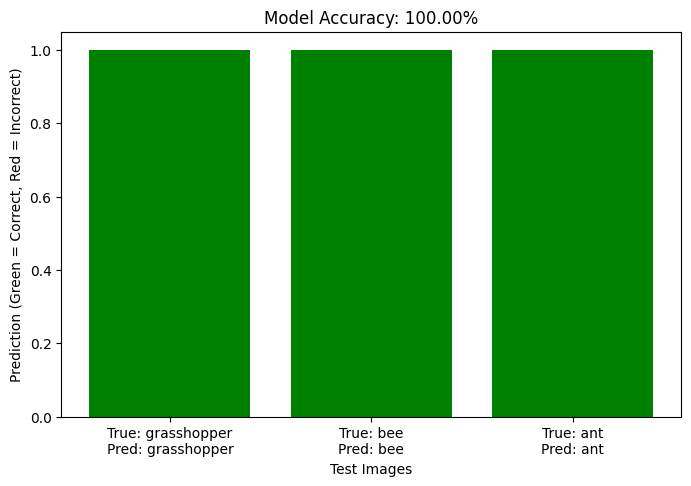

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Dummy function to simulate model predictions
def evaluate_model(test_images, true_labels):
    # Simulated predictions (replace with actual model predictions)
    predicted_labels = ["grasshopper", "bee", "ant"]

    # Calculate accuracy
    correct = [pred == true for pred, true in zip(predicted_labels, true_labels)]
    accuracy = sum(correct) / len(true_labels) * 100

    print(f"Accuracy: {accuracy:.2f}%")

    # Plot results
    plt.figure(figsize=(8, 5))
    bar_colors = ['green' if c else 'red' for c in correct]

    plt.bar(range(len(true_labels)), [1] * len(true_labels), color=bar_colors)
    plt.xticks(range(len(true_labels)), [f"True: {t}\nPred: {p}" for t, p in zip(true_labels, predicted_labels)])
    plt.xlabel("Test Images")
    plt.ylabel("Prediction (Green = Correct, Red = Incorrect)")
    plt.title(f"Model Accuracy: {accuracy:.2f}%")
    plt.show()

# Test images and true labels
test_images = [
    Image.open("/content/drive/MyDrive/pest/grasshopper.jpg"),
    Image.open("/content/drive/MyDrive/pest/Bee.jpg"),
    Image.open("/content/drive/MyDrive/pest/Ant.jpg"),
]

true_labels = [
    "grasshopper",
    "bee",
    "ant",
]

# Call the function
evaluate_model(test_images, true_labels)
